In [1]:
import pandas as pd

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pickle

### 1. Loading the data



In [8]:
df = pd.read_parquet('/Users/lynnelmoussaoui/Desktop/mlops2025_Lynn_Hadi/notebooks/yellow_tripdata_2023-01.parquet')

In [9]:
df.shape

(3066766, 19)

In [10]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [11]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

### 2. Computing duration

In [12]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() / 60

<Axes: xlabel='duration', ylabel='Count'>

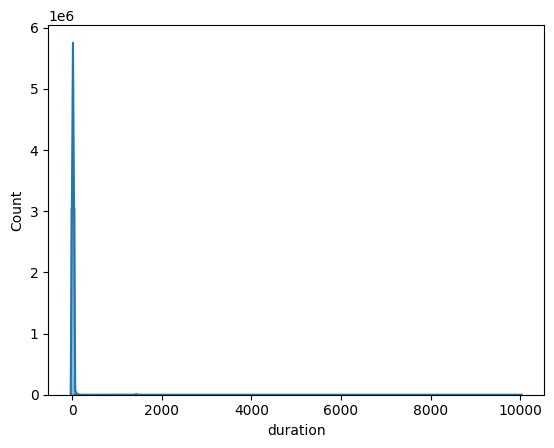

In [13]:
sns.histplot(df.duration, bins=100, kde=True)

In [14]:
df.duration.describe(percentiles=[.95, .98, .99])

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
50%      1.151667e+01
95%      3.646667e+01
98%      4.873333e+01
99%      5.725000e+01
max      1.002918e+04
Name: duration, dtype: float64

### 3. Dropping outliers

In [15]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.1220282212598

In [16]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [17]:
df.shape

(3009173, 20)

In [22]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'duration'],
      dtype='object')

<Axes: xlabel='duration', ylabel='Count'>

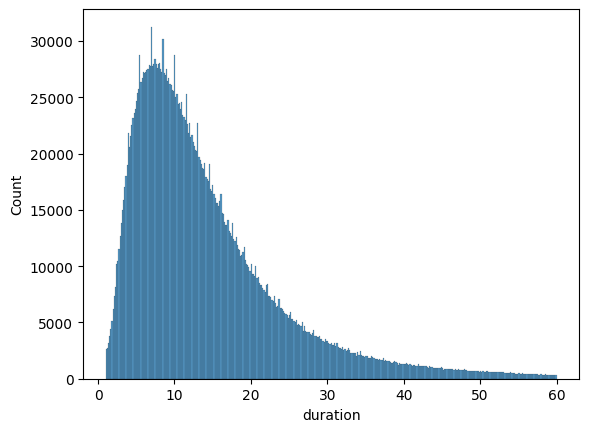

In [18]:
sns.histplot(df.duration)

### 4. One-hot encoding

In [19]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [20]:
categorical = ['PULocationID', 'DOLocationID']

In [25]:
categorical

['PULocationID', 'DOLocationID']

In [27]:
df.PULocationID

0          161
1           43
2           48
3          138
4          107
          ... 
3066761    107
3066762    112
3066763    114
3066764    230
3066765    262
Name: PULocationID, Length: 3009173, dtype: object

In [21]:
dv = DictVectorizer()

df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)

In [24]:
dv

,"dtype dtype: dtype, default=np.float64The type of feature values. Passed to Numpy array/scipy.sparse matrixconstructors as the dtype argument.",<class 'numpy.float64'>
,"separator separator: str, default=""=""Separator string used when constructing new features for one-hotcoding.",'='
,"sparse sparse: bool, default=TrueWhether transform should produce scipy.sparse matrices.",True
,"sort sort: bool, default=TrueWhether ``feature_names_`` and ``vocabulary_`` should besorted when fitting.",True


In [28]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6018346 stored elements and shape (3009173, 515)>

In [29]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


### 5. Training a model

In [ ]:
target = 'duration'
y_train = df[target].values

In [ ]:
lr = LinearRegression() # Ridge(0.8) # # Lasso(0.1) #, Ridge
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred)}')

In [ ]:
sns.histplot(y_train, label='actual')
sns.histplot(y_pred, label='prediction')

plt.legend()

### 6. Evaluating the model

In [ ]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [ ]:
df_val = read_data('../data/yellow_tripdata_2023-02.parquet')

In [ ]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [ ]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [ ]:
y_pred = lr.predict(X_val)

In [ ]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred)}')

In [ ]:
sns.histplot(y_val, label='actual')
sns.histplot(y_pred, label='prediction')

plt.legend()

### 7. Improve score

In [ ]:
df_train = read_data('../data/yellow_tripdata_2023-01.parquet')
df_val = read_data('../data/yellow_tripdata_2023-02.parquet')

In [ ]:
df_train

#### 7.1 Compute features

In [ ]:
# use ['PULocationID', 'DOLocationID'] as combined feature

df_train['PU_DO'] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val['PU_DO'] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [ ]:
df_train.head()

#### 7.2 Launch training

In [ ]:
categorical = ['PU_DO']
target = 'duration'

In [ ]:
dv = DictVectorizer()
train_dicts = df_train[categorical].to_dict(orient='records')

X_train = dv.fit_transform(train_dicts)
y_train = df_train[target].values


lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
print(f'Train RMSE: {mean_squared_error(y_train, y_train_pred)}')

In [ ]:
sns.histplot(y_train, label='actual')
sns.histplot(y_train_pred, label='prediction')

plt.legend()

#### 7.3 Run Validation

In [ ]:
val_dicts = df_val[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts) 
y_val = df_val[target].values

y_val_pred = lr.predict(X_val)
print(f'Train RMSE: {mean_squared_error(y_val, y_val_pred)}')

In [ ]:
sns.histplot(y_val, label='actual', bins=60)
sns.histplot(y_val_pred, label='prediction', bins=60)

plt.legend()

### 8. Save model

In [ ]:
with open('../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
!ls -al ../models

### 9. MLFlow

In [ ]:
import mlflow

In [ ]:
mlflow.set_tracking_uri(uri="sqlite:///../mlflow.db")

In [ ]:
mlflow.set_experiment("my-first-experiment")

In [ ]:
def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()
    
    return df

In [ ]:
train_data_path = '../data/yellow_tripdata_2023-01.parquet'
val_data_path = '../data/yellow_tripdata_2023-02.parquet'

In [ ]:
df_train = read_data(train_data_path)
df_val = read_data(val_data_path)

In [ ]:
# Prepare data
categorical = ['PULocationID', 'DOLocationID']

# cast types to string
df_train[categorical] = df_train[categorical].astype('str')
df_val[categorical] = df_val[categorical].astype('str')

# get columns as dict
train_dicts = df_train[categorical].to_dict(orient='records')
val_dicts = df_val[categorical].to_dict(orient='records')

# fit transform dict vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [ ]:
X_train.shape, X_val.shape

In [ ]:
y_train = df_train.duration.values
y_val = df_val.duration.values

In [ ]:
y_train.shape, y_val.shape

In [ ]:
with mlflow.start_run():
    mlflow.set_tag("dev", "naji")
    mlflow.set_tag("change", "preprocessing")
    mlflow.log_param("train dp", train_data_path)
    mlflow.log_param("val dp", val_data_path)

    # alpha = 0.5
    lr = LinearRegression() # Ridge(alpha)
    mlflow.log_param("model type", type(lr))
    # mlflow.log_param("alpha", alpha)
    
    lr.fit(X_train, y_train)
    
    y_train_pred = lr.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred)
    mlflow.log_metric("Train RMSE", train_rmse)
    
    y_val_pred = lr.predict(X_val)
    val_rmse = mean_squared_error(y_val, y_val_pred)
    mlflow.log_metric("Val RMSE", val_rmse)

In [ ]:
print(f'Train RMSE: {train_rmse}')
print(f'Val RMSE: {val_rmse}')